In [1]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu,SmoothingFunction
import pandas as pd
import numpy as np
import docker
import os
import re
import random
from string import punctuation
import json
import matplotlib.pyplot as plt
import pickle
punc = punctuation
smooth = SmoothingFunction()

In [5]:
#countGasRes
def countGasRes(data):
    #patNum = [1,6,2,3,4,7] 雀屏论文顺序有误 这个顺序对应1，2，3，4，5，6
    total = 0
    for item in [1,6,2,3,4,7]:
        print(item,end=' ')
        num = len(data[data['pattern{}'.format(item)].apply(lambda x : x != None and len(x) > 0)])
        print(num)
        total += num
    print(total)

#countBugRes
def smallerRange(oldNum, lineNum):
    if len(oldNum) < 1 or len(lineNum) < 1:
        print('great error')
        return False
    oldStart = oldNum[0]
    oldEnd = oldNum[-1]
    lineStart = lineNum[0]
    lineEnd = lineNum[-1]
    return lineStart >= oldStart and lineEnd <= oldEnd
def updateMap(res, title, lineNum):
    lineNum = [lineNum] if type(lineNum) == int else lineNum
    lineOldNum = res[title]
    for oldNum in lineOldNum:
        #print(oldNum)
        if smallerRange(oldNum, lineNum):
            return
    res[title].append(lineNum)
    
def subDict(dict1, dict2):
    res = {}
    for item in dict1.keys():
        if item not in dict2.keys():
            res[item] = dict1[item]
        elif dict1[item] - dict2[item] > 0:
            res[item] = dict1[item] - dict2[item]
    return res
    
def getCount(mapRes):
    resCount = {}
    for item in mapRes:
        if len(item) > 0:
            for bugName in item.keys():
                count = len(item[bugName])
                if bugName in resCount.keys():
                    resCount[bugName] += count
                else:
                    resCount[bugName] = count
    return resCount

toolNames = ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info']

def get(cc, toolNames):
    mapRes = []
    for index,row in cc.iterrows():
        #同行算消除
        res = {}
        for toolName in toolNames:
            #toolRes = row[toolName]
            toolRes =  eval(row[toolName]) if type(row[toolName]) == str else row[toolName]
            for tRes in toolRes:
                lineNum = tRes['lineno']
                title = mapp[toolName.split('_')[0]][tRes['title'].strip()]#已经转换过
                if title in res.keys():
                    updateMap(res, title, lineNum)
                else:
                    res[title] = [[lineNum] if type(lineNum) == int else lineNum]#使用lineNum--list的len计算数量 [[],[]]
            #temp = [res]
            #print(getCount(temp))
        mapRes.append(res)
    resCount =  getCount(mapRes)
    return resCount

def countBugRes(data):
    print('mythril: {}'.format( get(data, ['mythril_analysis_not_info']) ))
    print('osiris: {}'.format(subDict(get(data, ['mythril_analysis_not_info','osiris_analysis']), get(data, ['mythril_analysis_not_info']))))
    print('slither: {}'.format( subDict(get(data, ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info']), get(data, ['mythril_analysis_not_info','osiris_analysis'])) ))
    print('total:',end=' ')
    total = get(data, ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info'])
    count = 0
    for item in total:
        count += total[item]
    print(total)
    print(count)
#工具结果整合    
head = [' access_control ',
 ' arithmetic ',
 ' denial_service ',
 ' reentrancy ',
 ' unchecked_low_calls ',
 ' bad_randomness ',
 ' front_running ',
 ' time_manipulation ',
 ' short_addresses ',
 ' Other ',
 ' Ignore ']    
dic = dict(zip(head,[0]*10))
mapping = open('/home/yfliu/mapping.json').read()
mapp = json.loads(mapping)
slither_map = mapp['slither']
slither_key = slither_map.keys()
slither_type_map = dict(zip(slither_key,[0]*len(slither_key)))
u = open('/home/yfliu/paper/trash/temp.txt').read()
for i in u.splitlines():
    sp = i.split()
    slither_type_map[sp[1]] = sp[-2]
slither_type_map
slither_type_map['constant-function'] = 'Medium'
slither_bug_patch = ['constable-states','erc20-indexed','erc20-interface','external-function','incorrect-equality','naming-convention','shadowing-local','shadowing-state','shadowing-builtin','shadowing-abstract']    

In [10]:
conMan = pd.read_pickle('/home/yfliu/paper_data/manualResultCsv/contractResGas.pic')
funMan = pd.read_pickle('/home/yfliu/paper_data/manualResultCsv/functionResGas.pic')
runList = [conMan,funMan]

In [63]:
def checkBLEU(match):
    b = []
    for idx,row in match.iterrows():
        bleu = sentence_bleu([row['sni_code']],row['contract_code'],smoothing_function=smooth.method1)
        b.append((bleu))#
    return b
def checkBLEUS(match):
    b = []
    for idx,row in match.iterrows():
        bleu = sentence_bleu([row['sni_code']],row['contract_code'],smoothing_function=smooth.method1)
        b.append(("%.1f" % bleu))#
    return b
def anlysisBLEU(data):
    xRange = range(0,11)
    xRange = [str(item / 10) for item in list(xRange)]
    t = {}
    for item in xRange:
        t[item] = 0
    for item in data:
        t[item] += 1
    return t

In [2]:
#conMan = pd.read_pickle('/home/yfliu/paper_data/manualResultCsv/contractRes.pic')
conAst = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/contractRes.pic')
#conAstBleu = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/contractRes_bleu.pic')
#funMan = pd.read_pickle('/home/yfliu/paper_data/manualResultCsv/functionRes.pic')
funAst = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/functionRes.pic')
#funAstBleu = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/functionRes_bleu.pic')
runList = [conAst,funAst]

In [68]:
conAst = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/contractRes_v2.pic')
funAst = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/functionRes_v2.pic')

In [60]:
conBleu = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/contractResBleu.pic')
funBleu = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/functionResBleu.pic')

In [65]:
pd.read_pickle("/home/yfliu/paper_data/matchRes/nicad3ConMatch_0.5.pic")

,snippet,0
0,1835,"[23883, 56036]"
1,3068,[25081]
2,3057,"[50501, 61515, 13747, 62411, 50142, 67326, 524..."
3,2451,"[50501, 61515, 13747, 62411, 50142, 67326, 524..."
4,246,"[27760, 25530, 21061, 35746, 12750, 48342, 478..."
...,...,...
643,5218,[18397]
644,2080,[8042]
645,1371,"[35661, 68902, 55668, 2761, 2469, 7184, 37472,..."
646,3167,"[68192, 3699, 52982, 29759]"


In [51]:
conAst['bleu'] = checkBLEU(conAst)

In [ ]:
#>0.7 550 191

In [62]:
print(anlysisBLEU(checkBLEUS(conBleu)))
print(anlysisBLEU(checkBLEUS(funBleu)))

{'0.0': 136, '0.1': 148, '0.2': 146, '0.3': 83, '0.4': 47, '0.5': 9, '0.6': 0, '0.7': 2, '0.8': 1, '0.9': 2, '1.0': 0}
{'0.0': 89, '0.1': 104, '0.2': 90, '0.3': 45, '0.4': 11, '0.5': 2, '0.6': 1, '0.7': 0, '0.8': 0, '0.9': 0, '1.0': 0}


In [73]:
conB = anlysisBLEU(checkBLEUS(conAst))
funB = anlysisBLEU(checkBLEUS(funAst))
print(conB)
print(funB)

{'0.0': 50, '0.1': 12, '0.2': 21, '0.3': 48, '0.4': 119, '0.5': 126, '0.6': 115, '0.7': 111, '0.8': 98, '0.9': 212, '1.0': 208}
{'0.0': 0, '0.1': 3, '0.2': 36, '0.3': 28, '0.4': 56, '0.5': 87, '0.6': 70, '0.7': 68, '0.8': 77, '0.9': 134, '1.0': 50}


In [72]:
def barr(keys,values):
    fig = plt.figure(figsize=(8,4))
    plt.bar(keys, values)
    for a,b in zip(keys,values):
        plt.text(a, b+0.01, '%.0f' % b, ha='center', va= 'bottom')
    plt.xticks()
    #plt.xlabel("Distribution of contract duplication")
    #plt.ylabel("Contract count")
    plt.show()

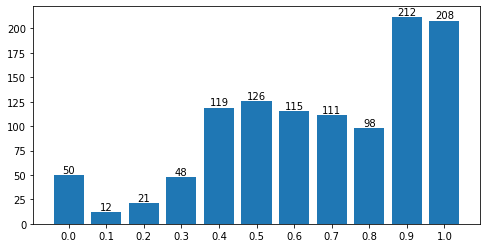

In [75]:

#num_count = [103,34,23,18,9,7,8,9,4,418]
barr(funB.keys(),conB.values())

In [6]:
#gas
for item in runList:
    countGasRes(item)
    print('-----------------')

1 115
6 345
2 7
3 6
4 33
7 14
520
-----------------
1 2
6 82
2 0
3 1
4 10
7 5
100
-----------------


In [7]:
#bug
for item in runList:
    countBugRes(item)
    print('------------------')

mythril: {' arithmetic ': 113, ' Other ': 11, ' front_running ': 11, ' reentrancy ': 11, ' access_control ': 4}
osiris: {' arithmetic ': 112, ' Ignore ': 27, ' time_manipulation ': 10, ' reentrancy ': 1, ' denial_service ': 1}
slither: {' Other ': 17, ' time_manipulation ': 6, ' reentrancy ': 20, ' unchecked_low_calls ': 20, ' denial_service ': 19, ' access_control ': 15}
total: {' arithmetic ': 225, ' Other ': 28, ' front_running ': 11, ' Ignore ': 27, ' time_manipulation ': 16, ' reentrancy ': 32, ' unchecked_low_calls ': 20, ' denial_service ': 20, ' access_control ': 19}
398
------------------
mythril: {' Other ': 6, ' front_running ': 12, ' arithmetic ': 68, ' reentrancy ': 13, ' access_control ': 2}
osiris: {' arithmetic ': 46, ' Ignore ': 8, ' time_manipulation ': 6, ' denial_service ': 2}
slither: {' Other ': 4, ' reentrancy ': 11, ' unchecked_low_calls ': 7, ' time_manipulation ': 1, ' access_control ': 6, ' denial_service ': 1}
total: {' Other ': 10, ' reentrancy ': 24, ' ari

In [ ]:
#getAcc


In [52]:
#diffuse -> http://localhost:8898/notebooks/paper_code/RQ6/RQ6.ipynb

In [5]:
#解决csv没法存储list的问题
'''
def evalItem(data):
    for item in data.columns:
        #print(item)
        data[item] = data[item].apply(lambda x : eval(x) if type(x) == str and '[' == x[0] else x)
    return data
conMan = pd.read_csv('/home/yfliu/paper_data/manualResultCsv/contractRes.csv')
conAst = pd.read_csv('/home/yfliu/paper_data/astResultCsv/contractRes.csv')
conAstBleu = pd.read_csv('/home/yfliu/paper_data/astResultCsv/contractResBleu.csv')
funMan = pd.read_csv('/home/yfliu/paper_data/manualResultCsv/functionRes.csv')
funAst = pd.read_csv('/home/yfliu/paper_data/astResultCsv/functionRes.csv')
funAstBleu = pd.read_csv('/home/yfliu/paper_data/astResultCsv/functionResBleu.csv')
evalItem(conMan).to_pickle('/home/yfliu/paper_data/manualResultCsv/contractRes.pic')
evalItem(conAst).to_pickle('/home/yfliu/paper_data/astResultCsv/contractRes.pic')
evalItem(conAstBleu).to_pickle('/home/yfliu/paper_data/astResultCsv/contractResBleu.pic')
evalItem(funMan).to_pickle('/home/yfliu/paper_data/manualResultCsv/functionRes.pic')
evalItem(funAst).to_pickle('/home/yfliu/paper_data/astResultCsv/functionRes.pic')
evalItem(funAstBleu).to_pickle('/home/yfliu/paper_data/astResultCsv/functionResBleu.pic')'''

In [ ]:
#对一个error 找到匹配对与定位位置，确定是否错误
#手工考虑增加结果，修改手工的匹配结果
#重新验证准确


In [ ]:
#修改手工结果

# 统计结果

In [ ]:
#统计Arithmetic的普遍出现

In [58]:
def bugRes(name, data):
    t = data[data[name].apply(lambda x : len(x) > 0)][name]
    ans = {}
    for item in t:
        for bug in item:
            if bug['title'] in ans.keys():
                ans[bug['title']] += 1
            else:
                ans[bug['title']] = 1
    return ans

In [72]:
def bugResGroupBy(name, data,r):
    t = data[data[name].apply(lambda x : len(x) > 0)][name]
    count = 0
    for item in t:
        temp = 0
        for bug in item:
            if bug['title'] in r:
                temp += 1
        if temp > 0:
            count += 1
    return count

In [73]:
osirisG = bugResGroupBy('osiris_analysis',conAst, ['overflow_bugs','underflow_bugs','truncation_bugs'])
osirisG

56

In [74]:
mythrilG = bugResGroupBy('mythril_analysis_not_info',conAst, ['Integer Overflow ','Integer Underflow'])
mythrilG

48

In [70]:
mythrilG = bugResGroupBy('mythril_analysis_not_info',conAst, ['Integer Overflow ','Integer Underflow'])
for item in mythrilG:
    if item in ttt.keys():
        ttt[item] += 1
    else:
        ttt[item] = 1
ttt

{3: 10, 1: 35, 2: 33, 4: 15, 6: 3, 8: 2, 11: 1, 10: 2, 9: 1, 5: 2}

In [60]:
osiris = bugRes('osiris_analysis',conAst)
osiris

{'overflow_bugs': 95,
 'concurrency_bug': 37,
 'time_dependency_bug': 10,
 'underflow_bugs': 45,
 'callstack_bug': 1,
 'truncation_bugs': 8,
 'reentrancy_bug': 1}

In [63]:
mythril = bugRes('mythril_analysis_not_info',conAst)
mythril

{'Integer Overflow ': 110,
 'Dependence on predictable environment variable': 11,
 'Transaction order dependence': 11,
 'Integer Underflow': 17,
 'Message call to external contract': 9,
 'State change after external call': 2,
 'Ether send': 3,
 'Unchecked SUICIDE': 1}

In [62]:
slither = bugRes('slither_analysis_not_info',conAst)
slither

{'reentrancy-no-eth': 6,
 'reentrancy-benign': 14,
 'uninitialized-local': 6,
 'timestamp': 6,
 'reentrancy-eth': 3,
 'unused-return': 20,
 'calls-loop': 19,
 'arbitrary-send': 11,
 'controlled-delegatecall': 2,
 'suicidal': 2,
 'locked-ether': 10,
 'uninitialized-storage': 1}

In [61]:
conAst.columns

Index(['index', 'sni_index', 'code_index', 'code_name', 'dealed_code',
       'sni_name', 'contract_code', 'sni_code', 'contract_line', 'name',
       'mythril', 'osiris', 'slither', 'osiris_analysis', 'mythril_analysis',
       'slither_analysis', 'pattern1', 'pattern6', 'pattern2', 'pattern3',
       'pattern4', 'pattern7', 'slither_analysis_not_info',
       'mythril_analysis_not_info'],
      dtype='object')

In [ ]:
#统计接受答案与不被接受答案

In [12]:
conAst = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/contractRes_v2.pic')
funAst = pd.read_pickle('/home/yfliu/paper_data/astResultCsv/functionRes_v2.pic')
def temp(name,data):
    return list(data[data[name].apply(lambda x : x != None and len(x) > 0)]['sni_name'])
con = temp('slither_analysis_not_info', conAst) + temp('mythril_analysis_not_info', conAst) + temp('osiris_analysis', conAst)
conG = temp('pattern1', conAst) + temp('pattern2', conAst) + temp('pattern3', conAst)+ temp('pattern4', conAst)+ temp('pattern6', conAst)+ temp('pattern7', conAst)
fun = temp('slither_analysis_not_info', funAst) + temp('mythril_analysis_not_info', funAst) + temp('osiris_analysis', funAst)
funG = temp('pattern1', funAst) + temp('pattern2', funAst) + temp('pattern3', funAst)+ temp('pattern4', funAst)+ temp('pattern6', funAst)+ temp('pattern7', funAst)


129

360

82

In [50]:
def count(con):
    acc = 0
    no = 0
    for item in con:
        temp = item.split('-')[1].split('.')[0]
        if temp == '1':
            acc += 1
        else:
            no += 1
    return acc,no
print(count(con)[0],end = ' ')
print(count(conAst['sni_name'])[0] - count(con)[0])
print(count(con)[1],end = ' ')
print(count(conAst['sni_name'])[1] - count(con)[1])

25 190
161 646


In [83]:
161 /(161 + 646)

0.20930232558139536

In [82]:
161/(646+161)

0.19950433705080545

In [51]:
print(count(fun)[0],end = ' ')
print(count(funAst['sni_name'])[0] - count(fun)[0])
print(count(fun)[1],end = ' ')
print(count(funAst['sni_name'])[1] - count(fun)[1])

19 78
86 392


In [84]:
19 /(19+78)

0.1958762886597938

In [85]:
86/(86+392)

0.1799163179916318